In [1]:
%matplotlib inline

# Housing Inventory - Explore

Foremost, let's get the data staged in our dataframe.

In [2]:
import sqlite3
import pandas as pd
from tabulate import tabulate

def create_connection(db_file: str) -> list:
    """
    Create a database connection to the SQLite database specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    conn = None
    cur = None
    try:
        conn = sqlite3.connect(db_file)
        cur = conn.cursor()
    except sqlite3.Error as e:
        print(e)
    return [conn, cur]


def close_connection(db_conn: sqlite3.Connection) -> None:
    return db_conn.close()


db_file = 'housing_inventory.db'
db_con, db_cur = create_connection(db_file)

query = """
WITH mortgage_monthly(year_month, mortgage_rate) AS (
    SELECT year_month, avg(mortgage_rate) from mortgage_rates
    group by year_month
)
SELECT  hi.total_listing_count as 'housing_inventory', bp.total_units as 'housing_permits',
        mm.mortgage_rate, pr.prime_rate, rc.credit, hi.cbsa_code, mm.year_month
FROM housing_inventory as hi
INNER JOIN building_permits bp
    on hi.year_month = bp.year_month and hi.cbsa_code = bp.cbsa_code
INNER JOIN mortgage_monthly mm
    on hi.year_month = mm.year_month
INNER JOIN prime_rates pr
    on hi.year_month = pr.year_month
INNER JOIN revolving_credit rc
    on hi.year_month = rc.year_month
"""
result2 = list(db_con.execute(query))
df = pd.read_sql_query(sql=query,con=db_con)
close_connection(db_con)

Let's check the count of observations before we start looking at both single and paired variables analysis in-depth.

In [3]:
print('We have {a} observations in our aggregate dataset.'.format(a=df.shape[0]))


We have 18534 observations in our aggregate dataset.


**EDA helper functions**

In [4]:
import math
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import seaborn as sns
sns.set(style="whitegrid")

def freeman_diaconis(data):
    quartiles = stats.mstats.mquantiles( data, [0.25, 0.5, 0.75])
    iqr = quartiles[2] - quartiles[ 0]
    n = len( data)
    h = 2.0 * (iqr/n**(1.0/3.0))
    return int( h)

def plot_hist_categorical(t_col: pd.Series, do_normalize: bool):
    data = t_col.value_counts(normalize=do_normalize)
    x = list(data.index.sort_values())
    width = 1 / 1.5
    figure = plt.figure(figsize=(8, 6))

    axes = figure.add_subplot(1, 1, 1)
    axes.bar(x, data, width, align="center", color="darkslategray")
    axes.set_xticks(x)
    axes.set_xticklabels(data.axes[0])
    axes.set_title(' '.join(['Distribution of', t_col.name.title()]))
    axes.set_xlabel(t_col.name.title())
    axes.set_ylabel('Percent' if do_normalize else 'Count')
    axes.xaxis.grid(False)

    plt.show()
    plt.close()
    return

def plot_hist_numeric(t_col: pd.Series, backup_step=2, multiplier_factor = 1):
    mn = int(t_col.min())
    mx = int(t_col.max())
    h = freeman_diaconis(t_col) * multiplier_factor
    if h == 0: h = backup_step
    bins = [i for i in range(mn, mx, h)]

    figure = plt.figure(figsize=(10, 6))
    axes = figure.add_subplot(1, 1, 1)
    axes.hist(t_col, bins=bins, color="darkslategray")
    axes.set_title(' '.join([t_col.name.title(), 'Distribution']))
    axes.set_xlabel(t_col.name.title())

    plt.show()
    plt.close()
    return

def plot_hist_numeric_custom(t_col: pd.Series, bins: list):
    figure = plt.figure(figsize=(10, 6))
    axes = figure.add_subplot(1, 1, 1)
    axes.hist(t_col, bins=bins, color="darkslategray")
    axes.set_title(' '.join([t_col.name.title(), 'Distribution']))
    axes.set_xlabel(t_col.name.title())

    plt.show()
    plt.close()
    return

def get_correlations(df: pd.DataFrame, colA: str, colB: str) -> dict:
    results = {}
    results['pearson'] = stats.pearsonr(df[colA], df[colB])[0]
    results['spearman'] = stats.spearmanr(df[colA], df[colB])[0]
    return results

def describe_by_category(my_data: pd.DataFrame, numeric: str, categorical: str, transpose=False):
    t_grouped = my_data.groupby(categorical)
    t_grouped_y = t_grouped[numeric].describe()
    if transpose:
        print(t_grouped_y.transpose())
    else:
        print(t_grouped_y)
    return t_grouped

def plot_scatter(my_data: pd.DataFrame, y_col: str, x_col: str):
    figure = plt.figure(figsize=(8, 6))
    axes = figure.add_subplot(1, 1, 1)
    axes.scatter(y=my_data[y_col], x=my_data[x_col], marker='o', color='darkslategray')
    axes.set_ylabel(y_col.title())
    axes.set_xlabel(x_col.title())
    axes.set_title(' '.join([y_col, 'vs.', x_col]))

    plt.show()
    plt.close()

def plot_by_category(my_data: pd.DataFrame, response_col: str, explanatory_col: str, relative: bool):
    n_cols = 3
    h = freeman_diaconis(my_data[response_col])
    grouped = my_data.groupby(explanatory_col)
    figure = plt.figure(figsize=(20, 6))

    n_rows = math.ceil(grouped.ngroups / n_cols)

    for plot_index, k in enumerate(grouped.groups.keys()):
        axes = figure.add_subplot(n_rows, n_cols, plot_index + 1)
        axes.hist(grouped[response_col].get_group(k), bins=h, color="darkslategray", density=relative, range=(0, 40))
        axes.set_title(
            ' '.join([str(k), explanatory_col.title(), '-', response_col.title(), '\ndistribution - Freeman Diaconis']))
        axes.set_xlabel(response_col)

    figure.tight_layout()
    plt.show()
    plt.close()
    return

# 1. Housing Inventory - EDA: Single Variable Analysis

- [housing_inventory](#housing_inventory)
- [housing_permits](#housing_permits)
- [mortgage_rate](#mortgage_rate)
- [credit](#credit)
- [prime_rate](#prime_rate)
- [cbsa_code](#cbsa_code)

<a id='housing_inventory'></a>

## 1.1 housing_inventory

First let's look at the housing inventory numbers. This is our explanatory variable, the total number of houses in inventory across CBSA codes for a year/month combination (note: we did use the month/year to associate records, but the time is irrelevant to the scope of this analysis and is, therefore, omitted). For purposes of this analysis, the housing inventory numbers come from the monthly 'total listing count' which the total of both active and pending (offers accepted by deal not closed) by month per geographic area. [1]

In [5]:
df['housing_inventory'].describe()

count     18534.000000
mean       3634.159599
std        8178.636988
min         118.000000
25%         657.000000
50%        1318.500000
75%        2963.000000
max      108702.000000
Name: housing_inventory, dtype: float64

The mean is quite a bit to the right of the median; so, there is a strong positive/right skew to this data.


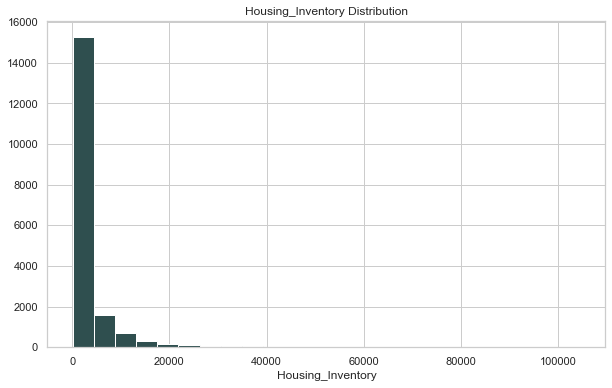

In [6]:
plot_hist_numeric(df['housing_inventory'], multiplier_factor=25)

This is much heavier skewed to the right than the tabular data indicated. Looking across all geographic areas, we can we there are many months when there are well less than 1,000 units available to buy or to rent.


<a id='housing_permits'></a>

## 1.2 housing_permits
Housing permits the subset of building permits (the approval given by a local governing entity across the United States) to commence with new constructtion.[2] Essentially building permits are a check to ensure that licensed contractors are going to be performing the work aligned with zoning restrictions and building codes. Let's look at the housing_permits. This is the number of housing permits per time period per cbsa code (geeographic area).

In [7]:
df['housing_permits'].describe()

count    18534.000000
mean       277.984636
std        609.632084
min          0.583333
25%         30.500000
50%         82.500000
75%        231.583333
max       5878.333333
Name: housing_permits, dtype: float64

Again, the mean number of housing permits is quite a bit larger than the median, so we can expect this to strongly right-skewed again.

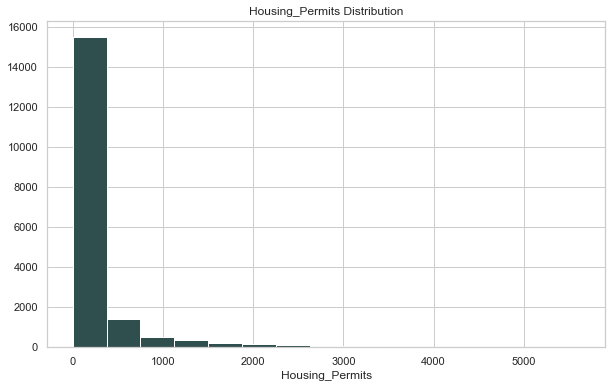

In [8]:
plot_hist_numeric(df['housing_permits'], multiplier_factor=25)

This has a very similar shape to the housing_inventory variable, but it is important to note the housing permit numbers are an order of magnitude less than the housing inventory numbers.

<a id='mortgage_rate'></a>

## 1.3 mortgage_rate

Mortgage rates are the loans individuals take out to purchase home. Federal Home Loan Mortgage Corporation (FHLMC), aka Freddie Mac, is a large, government-owned but publicly traded corporation that extends loans to many individuals. In addition to offering mortgage loans, they also do a weekly summary of mortgage rates of different types called the _Primary Mortgage Market Survey_.[3] For purposes of this analysis we focus on their aggregation and averaging of 30-year fixed rated mortgages.

In [9]:
df['mortgage_rate'].describe()

count    18534.000000
mean         3.760849
std          0.421753
min          2.684000
25%          3.465000
50%          3.880000
75%          4.045000
max          4.464000
Name: mortgage_rate, dtype: float64

For the mortgage rates, the mean is a little less than median, so we can expect this to have a slight negative skew.

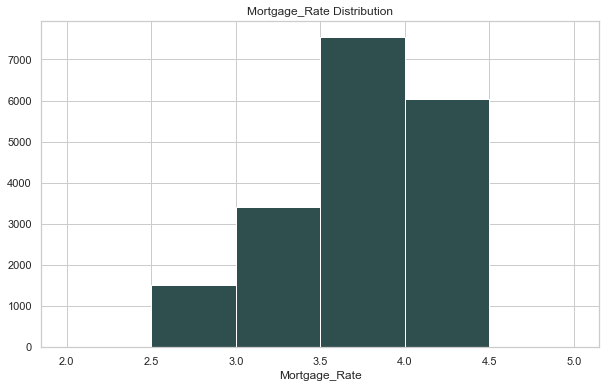

In [10]:
plot_hist_numeric_custom(df['mortgage_rate'],[2.0, 2.5, 3, 3.5, 4, 4.5, 5])

Looking at the visualization above, we can see that is the case as there is a slight negative skew with the most prevlant rate being between 3.5 and 4.0%.


<a id='prime_rate'></a>

## 1.4 prime_rate

The prime rate is an interest rate actually determined by individual banks and not the Federal Reserve itself; rather the Federal Reserve Board reports the 'prime rate' reported by the majority of the 25 largest banks. [4] Many of the other interest rates use the prime rate as their foundational rate on which to build.

In [11]:
df['prime_rate'].describe()

count    18534.000000
mean         4.188035
std          0.730339
min          3.250000
25%          3.640000
50%          4.130000
75%          4.750000
max          5.500000
Name: prime_rate, dtype: float64

The median and mean of the prime rate are really close around 4.1-4.2%; so, we might expect these rates to be normally distributed.

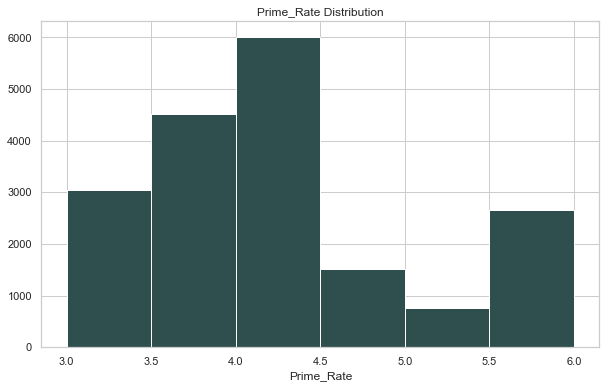

In [12]:
#plot_hist_numeric(df['prime_rate'], backup_step=.25)
plot_hist_numeric_custom(df['prime_rate'], [3, 3.5, 4, 4.5, 5, 5.5,6])

The visualization fo the prime rate is definitely not normally distributed; in fact is nearly appears to be bi-modal. Curiously the plot for the mortgage rate and the prime rates are not twin images as one might expect. Often 'folksy-wisdom' asserts that the mortgage rates always follow the prime rates; however, we can immediately see that the prime rates are actually greater than the mortgage rates.

<a id='credit'></a>

## 1.5 credit

The Federal Reserve defines consumer credit as "... most credit extended to individuals, excluding loans secured by real estate; includes receivables carried on the balance sheet of the institution as well as outstanding balances of pools upon which securities have been issued."[5] In aggregate millions of dollars per month, this essentially reflects how much credit, in aggregate, the individuals are using each month. More credit used means more bills that will need to be paid and cannot be obligated to housing costs.


In [13]:
df['credit'].describe()

count    1.853400e+04
mean     9.733881e+05
std      4.920682e+04
min      8.968570e+05
25%      9.376137e+05
50%      9.552190e+05
75%      1.016807e+06
max      1.091989e+06
Name: credit, dtype: float64

Looking at the summary revolving credit information, the mean is larger than the median; so, we would expect some positive, right-skewness, to the plot.


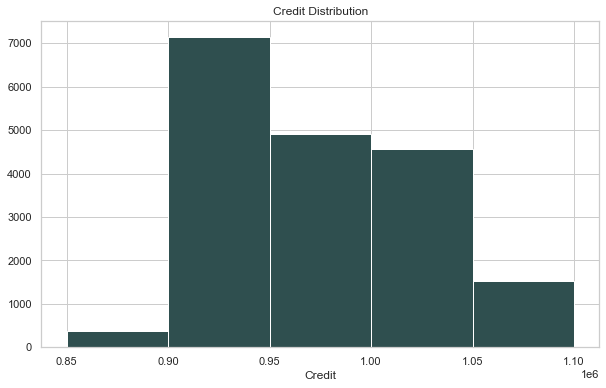

In [14]:
#plot_hist_numeric(df['credit'])
plot_hist_numeric_custom(df['credit'], [850000, 900000, 950000, 1000000, 1050000, 1100000])

Aligned with expectations, the visualization above is decidedly right-skewed.


<a id='cbsa_code'></a>

## 1.6 cbsa_code

The Core-Based Statistical Area codes are a set of metropolitan identifiers set by the Office of Management and Budget. [6] These are key to many of the macro-level economic calculations across the United States. For this analysis, these represent the geographic breakdowns of housing inventory data. While there also combined statistical areas (CSAs), this analysis leverages the CBSA codes as defined by OMB in 2015 (based on the 2010 Census). The total set of CBSA codes i s 935; so, let's see how many unique CBSA codes we have in our data set.[7]

In [15]:
print('Across this dataset, there are {a} unique CBSA codes'.format(a=df['cbsa_code'].nunique()))

Across this dataset, there are 383 unique CBSA codes


It looks like we have 383 unique CBSA codes in our dataset. This is substantially less than the 935 total. Let's do a quick check against the CBSA codes in the raw housing inventory data.

In [16]:
db_file = 'housing_inventory.db'
db_con, db_cur = create_connection(db_file)

query = """
SELECT count(distinct(cbsa_code)) from housing_inventory
"""
result = list(db_con.execute(query))
tabulate(result, headers=['Unique CBSA Codes'], tablefmt='html')

Unique CBSA Codes
917


Well 383 is definitely less than 917. This is probably do to the manner in which we inner-join across multiple tables to minimize missing data. In the future is would be good to re-analyze with meaningful approxiations/estimates instead of functionally dropping the entire observation.


Let's look at the number for each CBSA code we do have in our final aggregate dataset.

In [17]:
df['cbsa_code'].value_counts().sort_values(ascending=False)

33740    49
25420    49
41060    49
41140    49
24780    49
         ..
10180    22
10420    22
10540    22
10580    22
10500    22
Name: cbsa_code, Length: 383, dtype: int64

Looking at the counts, 49 is the expected number (12 months * 4 years + 1 extra month of data). 22 is interesting as is implies there are time-frames when certain areas did not provide data.

# 2. Housing Inventory - EDA: Paired Variable Analysis

Moving from the single variable analysis to the paired analysis, the relationships we are exploring to explain housing inventory across multiple datasets as expressed in the [Housing Inventory - Ask](Housing%20Inventory%20-%20Ask.ipynb) notebook, we should really look at correlations between each of the explanatory variables we've included

- [housing_permits](#v_housing_permits)
- [mortgage_rate](#v_mortgage_rate)
- [credit](#v_credit)
- [prime_rate](#v_prime_rate)
- [cbsa_code](#v_cbsa_code)

<a id='v_housing_permits'></a>

## 2.1 housing_inventory vs. housing_permits

Realistically, there should be some lag between the number of housing permits and the number of houses available in inventory at any point in time. Depending on particular localities with respect to work force availability and building supplies, it could take anywhere from 3 weeks to 6 months from the time a building permit is awarded to the time it is available in inventory. This caveat aside, given the time-agnostic focus of this study, we might expect the there to be a noticeable trend between the number of building permits issued and a rise in housing inventory. Let's check the correlation coefficients.

In [18]:
corr = get_correlations(df=df, colA='housing_inventory', colB='housing_permits')
print('Pearson\'s correlation coefficient is {a}\n\t and Spearman\'s rho is {b}'.format(a=round(corr['pearson'], 3),
                                                                                        b=round(corr['spearman'], 3)))

Pearson's correlation coefficient is 0.772
	 and Spearman's rho is 0.789


Both numeric measures indicate a strong positive correlation between housing inventory and housing permits. Let's check the scatter plot.


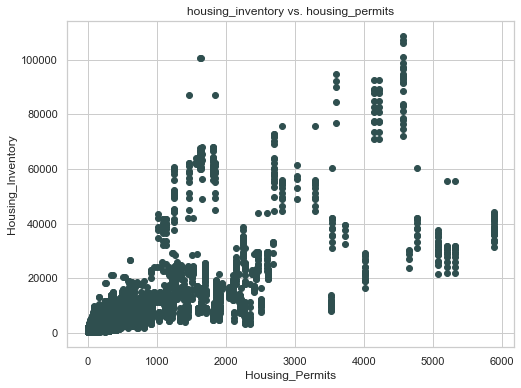

In [19]:
plot_scatter(my_data=df, y_col='housing_inventory', x_col='housing_permits')

While the plot is not the cleanest, there is still a clear positive correlation between the number of building permits issued and the number of houses in inventory.

<a id='v_mortgage_rate'></a>

## 2.2 housing_inventory vs. mortgage_rate

Given that higher mortgage rates lead to fewer people being able to afford new home loans (and secondarily potentially causing landlords to raise rent), we would expect a positive correlation between mortgage rates and housing inventory. Restated, the higher the mortgage rates, the more housing inventory we should expect. Let's check the correlation coefficients.

In [20]:
corr = get_correlations(df=df, colA='housing_inventory', colB='mortgage_rate')
print('Pearson\'s correlation coefficient is {a}\n\t and Spearman\'s rho is {b}'.format(a=round(corr['pearson'], 3),
                                                                                        b=round(corr['spearman'], 3)))

Pearson's correlation coefficient is 0.014
	 and Spearman's rho is 0.027


Mathematically, it looks like this is a very weak positive correlation. It is only weakly linear, and it is barely monotonic at that. Let's check the scatter plot.

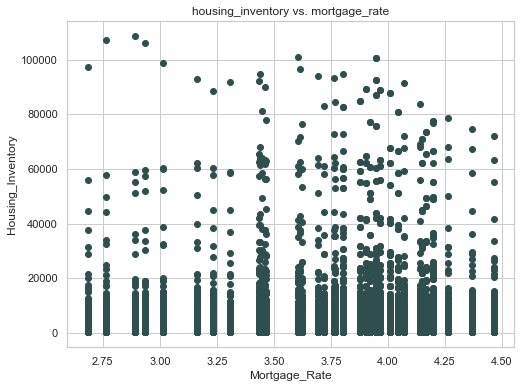

In [21]:
plot_scatter(my_data=df, y_col='housing_inventory', x_col='mortgage_rate')

This is interesting in that is illustrates there is almost no relationship between mortgage rates and housing inventory. While there are some outliers of high-inventory at low interest rates, on the whole, there is only a very small relationship between the mortgage rate and the available housing inventory.


<a id='v_credit'></a>

## 2.3 housing_inventory vs. credit

Outstanding revolving credit would be expected to have weak direct relation to an increase in housing inventory. If more people are taking on more debt (not associated with real estate), then that can be expected to correlate with fewer house purchases and a slight increase in housing inventory. Let's check the correlation coefficients.

In [22]:
corr = get_correlations(df=df, colA='housing_inventory', colB='credit')
print('Pearson\'s correlation coefficient is {a}\n\t and Spearman\'s rho is {b}'.format(a=round(corr['pearson'], 3),
                                                                                        b=round(corr['spearman'], 3)))

Pearson's correlation coefficient is -0.004
	 and Spearman's rho is -0.029


Very interesting as there appears to be **very slight** negative correlation; this would imply there is actually a slight decrease in housing inventory when people accumulate credit card debt. Perhaps the builders and other potential seller anticipate a tightening of the market and don't build as many or put their own house on the market, respectively. Moreover, aligned with this, Spearman's $\rho$ is also slightly negative; so, slightly monotonicly decreasing. Let's look at the scatter plot.


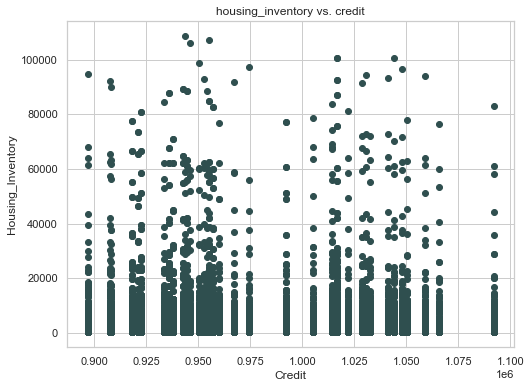

In [23]:
plot_scatter(my_data=df, y_col='housing_inventory', x_col='credit')

This plot is very similar in appearance to the housing inventory vs. mortgage rates visualization. There is no apparent correlation between the overall amount of outstanding credit (also, recall that each unit of credit is 1,000,000, to 1.1E6 on the graph is actually $1.1E12 across the population of the United States) and amount of housing inventory available.

<a id='v_prime_rate'></a>

## 2.4 housing_inventory vs. prime_rate

Given the prime rate actually the average rate of what large banks use for lending money and given that mortgage interest is a substantial revenue stream for most banks and credit unions, one would expect the prime rate and mortgage rate to be correlated strongly. Resultantly, here, we would expect the prime rate to look very similar to the mortgage rate. Let's check the correlation coeffients.

In [24]:
corr = get_correlations(df=df, colA='housing_inventory', colB='prime_rate')
print('Pearson\'s correlation coefficient is {a}\n\t and Spearman\'s rho is {b}'.format(a=round(corr['pearson'], 3),
                                                                                        b=round(corr['spearman'], 3)))

Pearson's correlation coefficient is 0.01
	 and Spearman's rho is 0.03


As expected, the prime rate has almost the exact correlation coefficient and Spearman's $\rho$ as the prime rate. Let's check the scatter plot.

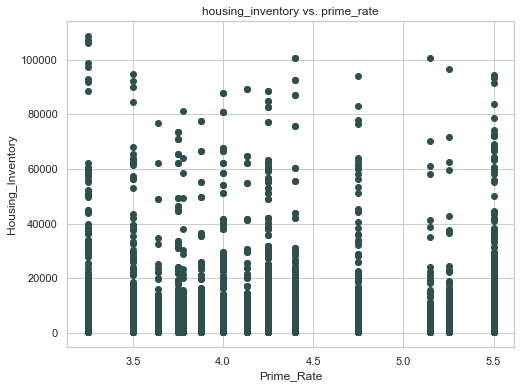

In [25]:
plot_scatter(my_data=df, y_col='housing_inventory', x_col='prime_rate')


As expected, the shape of the prime rate visualization is very similar to the shape of the mortgage rate visualization against housing inventory as the response variable. The only real difference of note is that the mortgage rate is actually slightly **lower** than the prime rate. At the surface, this does not make great sense as many of the advertisements for lending (credit cards, in particular) talk in terms of the prime rate plus a percentage. This is due to mortgage rates for 30-year fixed rate mortgages (like we are working to explain in this analysis) are tied to the 10-year Treasury bond rate.[8]


<a id='v_cbsa_code'></a>

## 2.5 housing_inventory vs. cbsa_code

As we are using raw CBSA codes without additional area aggregation, there is no expectation to identify codes with surge or decline in housing inventory. This caveat aside, let's tabulate the housing inventory by cbsa code.

In [26]:
t_grouped = df.groupby('cbsa_code')
t_grouped_y = t_grouped['housing_inventory'].describe().sort_values('max', ascending=False)
tabulate(t_grouped_y, headers=['cbsa','count','mean', 'sd', 'min','Q1','Q2','Q3','max'], tablefmt='html')

cbsa,count,mean,sd,min,Q1,Q2,Q3,max
35620,49,86560.6,9518.49,71012,77786,87955,92555,108702
33100,49,64501.4,8089.43,55865,60862,62713,66412,100541
16980,49,55000.9,9849.72,37543,49196,55123,60279,87076
12060,49,57171.9,8338.88,44674,51249,55387,60451,75770
26420,49,38722,5649.26,30913,35650,38369,41194,60356
19100,49,30507,6413.68,21691,27782,29896,31867,55633
31080,49,29995,4755.41,22720,26709,28996,33166,43724
37980,49,28422.6,10059.6,13678,20317,25284,38626,43653
45300,49,23337.5,4343.71,16036,21765,23161,24171,41888
47900,49,20175.4,5059.66,11811,16279,19618,24200,31085


Let's lookup the top three to see where they are at:

In [27]:
db_file = 'housing_inventory.db'
db_con, db_cur = create_connection(db_file)

query = """
SELECT distinct(cbsa_title)
from housing_inventory
WHERE cbsa_code = 35620
   OR cbsa_code = 33100
   OR cbsa_code = 16980

"""
result = list(db_con.execute(query))
tabulate(result, headers=['CBSA Title'], tablefmt='html')

CBSA Title
"new york-newark-jersey city, ny-nj-pa"
"chicago-naperville-elgin, il-in-wi"
"miami-fort lauderdale-west palm beach, fl"


Interesting the top areas in aggregate across the 49 time reporting periods are the composite metro areas across New York-Jersey City, Chicago-Naperville-Elgin, and Miami-Ft. Lauderdale-West Palm Beach areas. Intuitively, one might have thought that a Southern California area might break into the top three.

---

# References

[1]  Realtor.com. (n.d.). Realtor.com Real Estate Data and Market Trends for Download. Realtor.Com Economic Research. Retrieved November 28, 2021, from https://www.realtor.com/research/data/

[2] US Census Bureau (MCD): Cheryl Cornish, Stephen Cooper, Salima Jenkins. (n.d.). Building Permits Survey Definitions Page. Census Bureau. Retrieved November 28, 2021, from https://www.census.gov/construction/bps/definitions/#b

[3] Freddie Mac. (2021, November 24). Mortgage Rates - Freddie Mac. Mortgage Rates. Retrieved November 28, 2021, from http://www.freddiemac.com/pmms/

[4] Federal Reserve. (n.d.). The Fed - What is the prime rate, and does the Federal Reserve set the prime rate? Board of Governors of the Federal Reserve System. Retrieved November 28, 2021, from https://www.federalreserve.gov/faqs/credit_12846.htm

[5] The Fed - Consumer Credit - G.19. (n.d.). Consumer Credit. Retrieved November 28, 2021, from https://www.federalreserve.gov/Releases/g19/current/

[6] United States Federal Government. (n.d.). Core Based Statistical Areas (National) - CKAN. Data.Gov. Retrieved November 28, 2021, from https://catalog.data.gov/dataset/core-based-statistical-areas-national

[7] Wikipedia contributors. (2021, July 14). Core-based statistical area. Wikipedia. Retrieved November 29, 2021, from https://en.wikipedia.org/wiki/Core-based_statistical_area

[8] Ostrowski, J. (2021, September 23). How The Fed’s Rate Decisions Affect Mortgage Rates. Bankrate. Retrieved November 30, 2021, from https://www.bankrate.com/mortgages/federal-reserve-and-mortgage-rates/